#  폐렴(Pneumonia)을 찾아내는 딥러닝 모델
- 정상적인 흉부 X-RAY : 음영 영역이 없는 깨끗한 폐


- 비정상적인 흉부 X-RAY
    1. 세균성 폐렴 : 오른쪽 상부 엽 (흰색 화살표)에 있음
    2. 바이러스성 폐렴 : 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴

# 사용할 데이터
- 캐글의 Chest X-Ray Images (Pneumonia)
- 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상
- 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있음
- 전체 데이터의 크기는 총 1.2GB 가량 됨

# 1. Set-up

In [74]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [152]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 20
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 가져오기

In [153]:
# 각 데이터들의 개수 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train : ", len(train_filenames))
print("test : ", len(test_filenames))
print("val : ", len(val_filenames))

train :  5216
test :  624
val :  16


개수 비는 89%, 10.7%, 0.3% 이다.      
val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와본다.

In [154]:
# train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train : ", len(train_filenames))
print("val : ", len(val_filenames))

train :  4185
val :  1047


In [155]:
# train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [156]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


# Batch size 의 개념
- Batch Size 란 머신러닝이 데이터를 학습하는 과정에서 최적화(Gradient descent) 할 때 한번에 몇개의 데이터를 가지고 하는 지를 나타낸다.
-  1번 학생은 100개의 데이터를 보고 최적화(정답보고 향상시키고..) 하고 2번학생은 10개의 데이터를 보고 최적화(정답보고 향상시키고..) 한다.

# 왜 사용할까?
- 데이터가 엄청나게 많은 경우 전체데이터를 보고 최적화를 할 때 엄청난 시간이 할애할 수 있다.
- 그래서 정확도는 좀 떨어지지만 Batch Size를 줄여서 시간을 단축시키는 것

In [157]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [158]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [159]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다.

In [160]:
# 이미지를 알맞은 형식으로 바꿉니다.
#  이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
# get_label을 이용해서 라벨 값을 가져온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋 만들기

In [161]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [162]:
for image, label in train_ds.take(1): # train_ds.take(1) : 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


test 데이터 셋 만들기

In [163]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("TEST_IMAGE_COUNT : ", TEST_IMAGE_COUNT)

TEST_IMAGE_COUNT :  624


In [164]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
    ds = ds.repeat() # 여러 번 데이터셋을 사용할 수 있게 해준다.
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE에서 정한 만큼의 배치로 주어진다.
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어옴 -> 리소스의 유휴 상태를 줄일 수 있다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

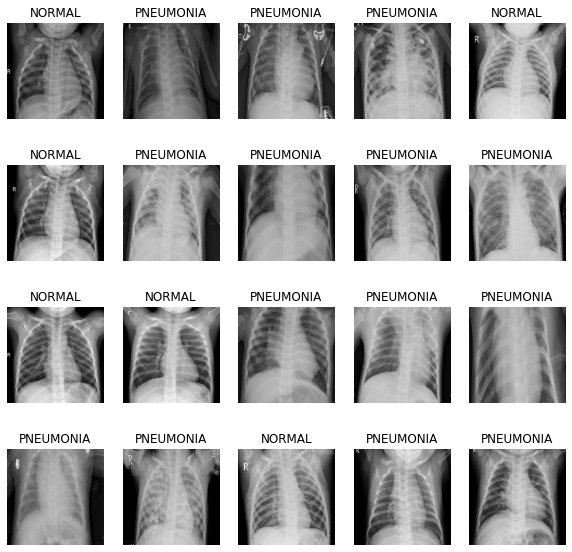

In [165]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [166]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [167]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [168]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리
- imbalance : 한 라벨이 너무 많은 경우
- 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.


**1. Weight balancing** :  training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법     


- 가중치 두는 방법(더 큰 정확도를 가져야하는 클래스를 고르는 방법)

> 원하는 클래스의 데이터의 loss 에는 특정 값을 곱하고, 이를 통해 딥러닝 모델을 트레이닝하는 것   

> 클래스의 비율에 따라 가중치를 두는 방법

**2. Over and under sampling** : 똑같은 데이터를 그대로 복사하는 것이기 때문에 새로운 데이터는 기존 데이터와 같은 성질을 갖게된다

출처: https://3months.tistory.com/414 [Deep Play]

In [169]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

In [170]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )

In [171]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 60s 242ms/step - loss: 0.4450 - accuracy: 0.8024 - precision: 0.9486 - recall: 0.7766 - val_loss: 0.6576 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 50s 238ms/step - loss: 0.2381 - accuracy: 0.9110 - precision: 0.9717 - recall: 0.9066 - val_loss: 0.8931 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 49s 237ms/step - loss: 0.2021 - accuracy: 0.9220 - precision: 0.9777 - recall: 0.9161 - val_loss: 1.2704 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 49s 237ms/step - loss: 0.1722 - accuracy: 0.9366 - precision: 0.9775 - recall: 0.9362 - val_loss: 0.0860 - val_accuracy: 0.9721 - val_precision: 0.9842 - val_recall: 0.9778
Epoch 5/30
209/209 [==============================] - 50s 241ms/step - loss: 0.1442 - accura

# 7. 결과 확인

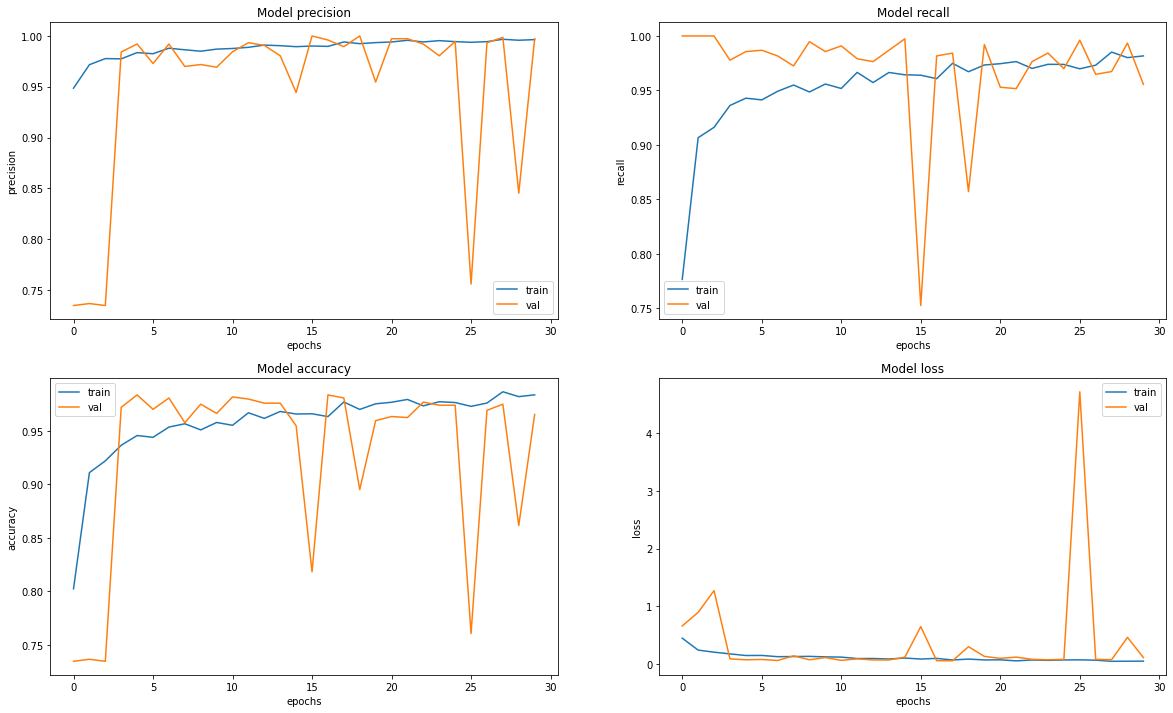

In [174]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [175]:
# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 4s 130ms/step - loss: 0.8404 - accuracy: 0.8590 - precision: 0.8283 - recall: 0.9769
Loss: 0.8403509259223938,
Accuracy: 0.8589743375778198,
Precision: 0.8282608985900879,
Recall: 0.9769230484962463


# BATCH_SIZE와 EPOCHS 조정
**1차 시도**         
BATCH_SIZE = 13          
EPOCHS = 50            
accuracy: 0.7163 - precision: 0.6878 - recall: 1.0000           

**2차 시도**           
BATCH_SIZE = 13         
EPOCHS = 50                     
accuracy: 0.7131 - precision: 0.6854 - recall: 1.0000          

**3차 시도**        
BATCH_SIZE = 20            
EPOCHS = 25                
accuracy: 0.8429 - precision: 0.8106 - recall: 0.9769           

**4차 시도**      
BATCH_SIZE = 16        
EPOCHS = 10                          
accuracy: 0.7436 - precision: 0.7122 - recall: 0.9897                 

**5차 시도**            
BATCH_SIZE = 20     
EPOCHS = 26       
accuracy: 0.7853 - precision: 0.7462 - recall: 0.9949       

**6차 시도**          
BATCH_SIZE = 32        
EPOCHS = 20           
accuracy: 0.8365 - precision: 0.8051 - recall: 0.9744           

**7차 시도**       
BATCH_SIZE = 32       
EPOCHS = 25       
accuracy: 0.8029 - precision: 0.7675 - recall: 0.9821         

**8차 시도**            
BATCH_SIZE = 32          
EPOCHS = 18            
accuracy: 0.7885 - precision: 0.7510 - recall: 0.9897          

**9차 시도**      
BATCH_SIZE = 32          
EPOCHS = 30      
accuracy: 0.7019 - precision: 0.6771 - recall: 1.0000

**10차 시도**           
BATCH_SIZE = 20       
EPOCHS = 30           
accuracy: 0.8590 - precision: 0.8283 - recall: 0.9769

# Data augmentation
- 이미지의 데이터를 좌우 반전시켜 데이터를 증가
- 데이터의 밝기를 조정해서 정확도 올릴 예정

In [176]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    image = tf.image.random_brightness(image, 0.5) # 밝기 조정
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [177]:
BATCH_SIZE = 20
EPOCHS = 30

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  #라벨이 2가지이기 때문
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/30
209/209 [==============================] - 60s 240ms/step - loss: 0.5570 - accuracy: 0.7081 - precision: 0.9062 - recall: 0.6777 - val_loss: 0.5887 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 49s 236ms/step - loss: 0.3130 - accuracy: 0.8689 - precision: 0.9648 - recall: 0.8550 - val_loss: 0.6255 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 49s 236ms/step - loss: 0.2440 - accuracy: 0.8974 - precision: 0.9705 - recall: 0.8890 - val_loss: 1.0980 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 50s 239ms/step - loss: 0.2124 - accuracy: 0.9208 - precision: 0.9731 - recall: 0.9190 - val_loss: 0.1291 - val_accuracy: 0.9423 - val_precision: 0.9346 - val_recall: 0.9908
Epoch 5/30
209/209 [==============================] - 51s 243ms/step - loss: 0.2046 - accura

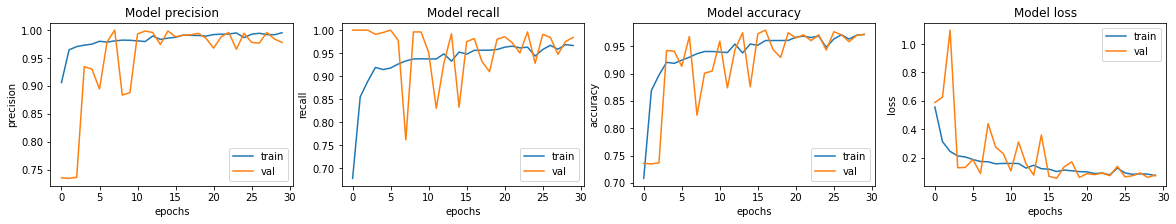

In [178]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [179]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 4s 128ms/step - loss: 1.2391 - accuracy: 0.7372 - precision: 0.7077 - recall: 0.9872
Loss: 1.2390894889831543,
Accuracy: 0.7371794581413269,
Precision: 0.7077205777168274,
Recall: 0.9871794581413269


# 회고
- 정확도를 올리기 위해 BATCH_SIZE와 EPOCHS 조정과 Data augmentation를 시도했다.
1. 하이퍼 파라미터 조정 : BATCH_SIZE와 EPOCHS 조정하면 적절한 하이퍼 파라미터를 찾는데 많은 시간이 걸렸다. 하이퍼 파라미터를 여러 번 조정하여 Accuracy 기준 85%에 도달했다.
2. Data augmentation : 이미지의 좌우반전을 이용과 밝기 조절을 이용한 Data augmentation를 시도했지만 하이퍼 파라미터에 비교했을 때 오히려 Accuracy가 떨어져 성능향상에 큰 영향을 주지 못했다.
- Data augmentation를 하면 더 좋은 성능이 나올 것이라고 기대했는데 하이퍼 파리미터를 조정하는 것만으로도 성능을 올릴 수 있었다. 같은 조원분을 통해 성능을 향상 시킬 수 있는 방법으로 이미지 회전, 가우시안 노이즈 추가 방법, learning rate조절을 알게 되어 앞으로 더 다양한 시도를 해야겠다.